---
## 1. Problem Definition

### Target Variable (What do we want to predict?)
**`monthly_salary_eur`** - The monthly gross salary in euros.

This is a **regression problem** since we are predicting a continuous numerical value (salary amount).

### Features (What information do we use for prediction?)
We will use the following features to predict salary:

| Feature | Description | Type |
|---------|-------------|------|
| `source_language` | Survey language (fi/en) - proxy for Finnish vs foreign workers | Categorical |
| `age` | Age group of the respondent | Categorical |
| `gender` | Gender of the respondent | Categorical |
| `experience_years` | Years of professional experience | Numerical |
| `company_type` | Type of company (consulting, product, etc.) | Categorical |
| `role_group` | Grouped job role category | Categorical |
| `education_level` | Highest education level achieved | Categorical |
| `location_category` | Work location (capital region vs rest of Finland) | Categorical |
| `office_time_percent` | Percentage of time spent in office | Numerical |

### Why these features?
- **Source language** is a proxy for nationality - do foreign workers (who likely answered in English) earn the same as Finnish workers?
- **Experience and education** are traditional salary predictors
- **Location** matters due to cost of living differences in Finland

- **Company type and role** reflect different compensation structures in the industry- **Age** may correlate with career progression

---
## 2. Collect & Load Data

In [55]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")


Libraries imported successfully!


In [56]:
# Load the cleaned dataset
df = pd.read_csv('processed/koodiklinikka_salary_survey_2024_cleaned.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")


Dataset loaded: 539 rows, 19 columns

Columns: ['source_language', 'age', 'gender', 'experience_years', 'monthly_salary_eur', 'annual_income_eur', 'income_change_pct', 'company', 'company_type', 'role', 'role_en', 'role_group', 'education', 'education_en', 'education_level', 'office_city', 'location_category', 'office_time_percent', 'salary_competitive']


---
## 3. Data Exploration

In [57]:
# Display first few rows
print("=" * 60)
print("FIRST 5 ROWS OF DATA")
print("=" * 60)
df.head()


FIRST 5 ROWS OF DATA


,source_language,age,gender,experience_years,monthly_salary_eur,annual_income_eur,income_change_pct,company,company_type,role,role_en,role_group,education,education_en,education_level,office_city,location_category,office_time_percent,salary_competitive
0,fi,46-50,male,27.0,7250.0,96000.0,3.0,NaN,konsulttitalossa,senior fullstack developer,senior fullstack developer,senior developer,ylioppilas,high school (ylioppilas),secondary or less,"pk-seutu (helsinki, espoo, vantaa)",capital region,80.0,true
1,fi,31-35,male,11.0,5100.0,65200.0,2.0,NaN,"yrityksessä, jossa softa on tukeva toiminto (e...",site reliability engineer,site reliability engineer,devops / infrastructure,tietotekniikan kandidaatti,bsc (computer science),bachelor,"pk-seutu (helsinki, espoo, vantaa)",capital region,10.0,true
2,fi,36-40,male,12.0,5850.0,105000.0,0.0,NaN,konsulttitalossa,fullstack developer,fullstack developer,software developer / engineer,ylioppilas,high school (ylioppilas),secondary or less,"pk-seutu (helsinki, espoo, vantaa)",capital region,5.0,true
3,fi,41-45,male,15.0,6800.0,81600.0,NaN,NaN,"tuotetalossa, jonka core-bisnes on softa",lead,lead,other,di,msc (engineering),master,tampere,rest of finland,30.0,true
4,fi,41-45,female,9.0,4730.0,61500.0,0.0,NaN,"tuotetalossa, jonka core-bisnes on softa","software developer, fullstack clojure/script","software developer, fullstack clojure/script",software developer / engineer,it-tradenomi,bachelor's it (amk),bachelor,helsinki & tampere,capital region,20.0,true


In [58]:
# Basic statistics for numerical columns
print("=" * 60)
print("BASIC STATISTICS - NUMERICAL COLUMNS")
print("=" * 60)
df.describe()


BASIC STATISTICS - NUMERICAL COLUMNS


,experience_years,monthly_salary_eur,annual_income_eur,income_change_pct,office_time_percent
count,532.000000,539.000000,479.000000,514.000000,536.000000
mean,11.426786,5775.664712,73174.517745,5.207023,32.986194
std,6.667182,1506.852552,34359.072260,9.256913,32.956402
min,0.000000,1890.000000,0.000000,-40.000000,0.000000
25%,6.000000,4800.000000,59187.500000,0.000000,5.000000
50%,10.000000,5690.000000,71800.000000,3.000000,20.000000
75%,15.000000,6514.500000,84750.000000,7.000000,52.500000
max,35.000000,12500.000000,462000.000000,60.000000,100.000000


In [59]:
# Check for missing values in our target and features
print("=" * 60)
print("MISSING VALUES COUNT")
print("=" * 60)
features_to_check = ['monthly_salary_eur', 'source_language', 'age', 'gender', 'experience_years', 
                     'company_type', 'role_group', 'education_level', 
                     'location_category', 'office_time_percent']

for col in features_to_check:
    missing = df[col].isna().sum()
    pct = (missing / len(df)) * 100
    print(f"{col}: {missing} missing ({pct:.1f}%)")


MISSING VALUES COUNT
monthly_salary_eur: 0 missing (0.0%)
source_language: 0 missing (0.0%)
age: 2 missing (0.4%)
gender: 41 missing (7.6%)
experience_years: 7 missing (1.3%)
company_type: 5 missing (0.9%)
role_group: 0 missing (0.0%)
education_level: 0 missing (0.0%)
location_category: 0 missing (0.0%)
office_time_percent: 3 missing (0.6%)


TARGET VARIABLE: monthly_salary_eur
count      539.000000
mean      5775.664712
std       1506.852552
min       1890.000000
25%       4800.000000
50%       5690.000000
75%       6514.500000
max      12500.000000
Name: monthly_salary_eur, dtype: float64


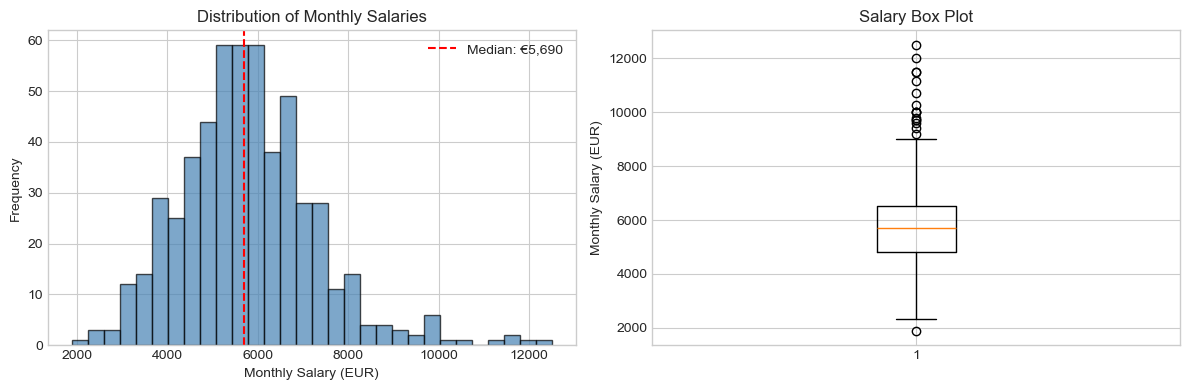

In [60]:
# Target variable distribution
print("=" * 60)
print("TARGET VARIABLE: monthly_salary_eur")
print("=" * 60)

salary_stats = df['monthly_salary_eur'].describe()
print(salary_stats)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df['monthly_salary_eur'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Monthly Salary (EUR)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Monthly Salaries')
axes[0].axvline(df['monthly_salary_eur'].median(), color='red', linestyle='--', label=f'Median: €{df["monthly_salary_eur"].median():,.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['monthly_salary_eur'].dropna(), vert=True)
axes[1].set_ylabel('Monthly Salary (EUR)')
axes[1].set_title('Salary Box Plot')

plt.tight_layout()
plt.show()


In [61]:
# Explore categorical features
print("=" * 60)
print("CATEGORICAL FEATURES DISTRIBUTION")
print("=" * 60)

categorical_cols_explore = ['source_language', 'age', 'gender', 'role_group', 'education_level', 'location_category']

for col in categorical_cols_explore:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts())


CATEGORICAL FEATURES DISTRIBUTION

SOURCE_LANGUAGE:
source_language
fi    495
en     44
Name: count, dtype: int64

AGE:
age
36-40    148
31-35    147
26-30     90
41-45     87
46-50     41
21-25     11
51-55      9
15-20      2
> 55v      2
Name: count, dtype: int64

GENDER:
gender
male      420
female     65
other      13
Name: count, dtype: int64

ROLE_GROUP:
role_group
software developer / engineer    225
senior developer                 107
other                             47
lead developer                    34
devops / infrastructure           32
management / leadership           30
data / ml / analytics             25
architect                         25
product / project                  7
design / ux                        5
junior developer                   2
Name: count, dtype: int64

EDUCATION_LEVEL:
education_level
master               210
bachelor             176
other                 57
secondary or less     44
unknown               31
vocational            17
phd     

SALARY BY SURVEY LANGUAGE (Finnish vs English respondents)

This compares salaries between Finnish-speaking (fi) and English-speaking (en)
respondents. English speakers are likely foreigners working in Finland.

                 Count  Mean Salary  Median Salary  Std Dev
source_language                                            
en                  44       5676.0         5585.0   1608.0
fi                 495       5785.0         5700.0   1499.0

📊 KEY FINDING:
   English respondents median salary: €5,585
   Finnish respondents median salary: €5,700
   Difference: €-115 (-2.0%)


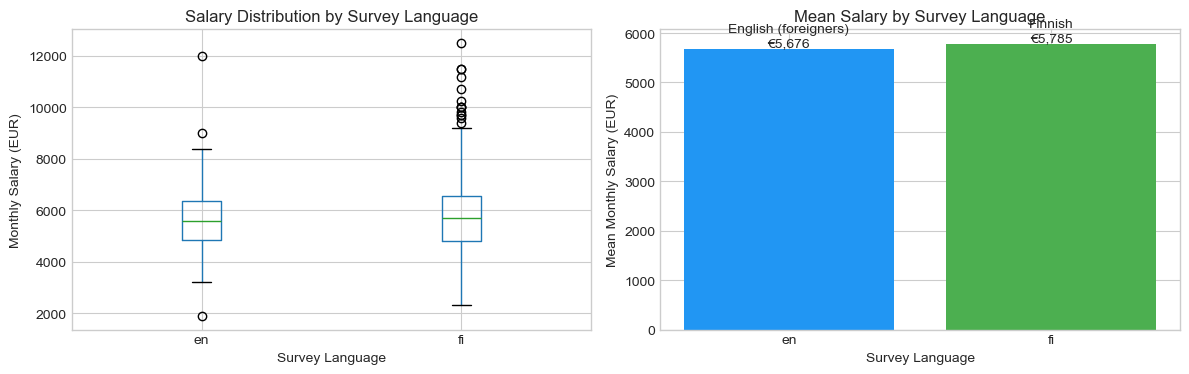

In [62]:
# Analyze salary difference between Finnish and English respondents (proxy for nationality)
print("=" * 60)
print("SALARY BY SURVEY LANGUAGE (Finnish vs English respondents)")
print("=" * 60)
print("\nThis compares salaries between Finnish-speaking (fi) and English-speaking (en)")
print("respondents. English speakers are likely foreigners working in Finland.\n")

salary_by_lang = df.groupby('source_language')['monthly_salary_eur'].agg(['count', 'mean', 'median', 'std'])
salary_by_lang.columns = ['Count', 'Mean Salary', 'Median Salary', 'Std Dev']
print(salary_by_lang.round(0))

# Calculate the difference
fi_median = df[df['source_language'] == 'fi']['monthly_salary_eur'].median()
en_median = df[df['source_language'] == 'en']['monthly_salary_eur'].median()
diff = en_median - fi_median
pct_diff = (diff / fi_median) * 100

print(f"\n📊 KEY FINDING:")
print(f"   English respondents median salary: €{en_median:,.0f}")
print(f"   Finnish respondents median salary: €{fi_median:,.0f}")
print(f"   Difference: €{diff:,.0f} ({pct_diff:+.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Box plot
df.boxplot(column='monthly_salary_eur', by='source_language', ax=axes[0])
axes[0].set_xlabel('Survey Language')
axes[0].set_ylabel('Monthly Salary (EUR)')
axes[0].set_title('Salary Distribution by Survey Language')
plt.suptitle('')  # Remove automatic title

# Bar chart of means
lang_means = df.groupby('source_language')['monthly_salary_eur'].mean()
colors = ['#4CAF50' if x == 'fi' else '#2196F3' for x in lang_means.index]
axes[1].bar(lang_means.index, lang_means.values, color=colors)
axes[1].set_xlabel('Survey Language')
axes[1].set_ylabel('Mean Monthly Salary (EUR)')
axes[1].set_title('Mean Salary by Survey Language')
for i, (lang, val) in enumerate(lang_means.items()):
    label = 'Finnish' if lang == 'fi' else 'English (foreigners)'
    axes[1].annotate(f'{label}\n€{val:,.0f}', xy=(i, val), ha='center', va='bottom')

plt.tight_layout()
plt.show()


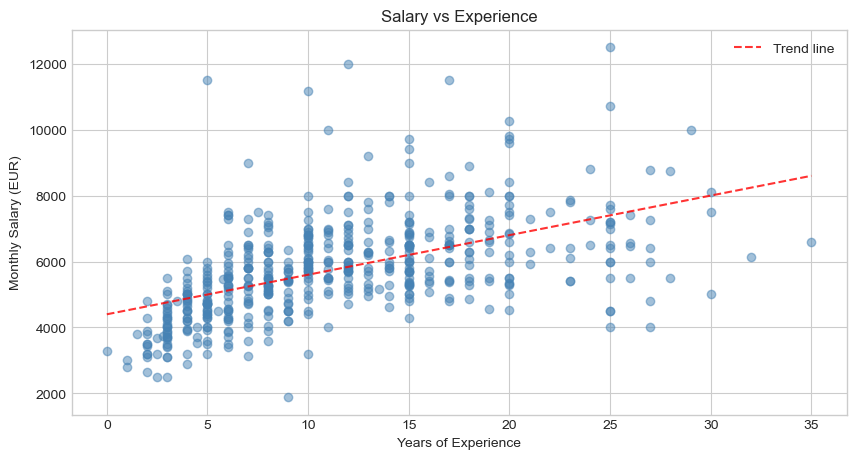

In [63]:
# Salary by experience (scatter plot)
plt.figure(figsize=(10, 5))
plt.scatter(df['experience_years'], df['monthly_salary_eur'], alpha=0.5, color='steelblue')
plt.xlabel('Years of Experience')
plt.ylabel('Monthly Salary (EUR)')
plt.title('Salary vs Experience')

# Add trend line
mask = ~df['experience_years'].isna() & ~df['monthly_salary_eur'].isna()
z = np.polyfit(df.loc[mask, 'experience_years'], df.loc[mask, 'monthly_salary_eur'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['experience_years'].min(), df['experience_years'].max(), 100)
plt.plot(x_line, p(x_line), "r--", alpha=0.8, label='Trend line')
plt.legend()
plt.show()


---
## 4. Clean & Prepare Data

In [64]:
# Select features for the model
feature_columns = [
    'source_language',  # fi = Finnish respondent, en = likely foreigner
    'age',
    'gender',
    'experience_years',
    'company_type',
    'role_group',
    'education_level',
    'location_category',
    'office_time_percent'
]

target_column = 'monthly_salary_eur'

# Create a copy for modeling
df_model = df[feature_columns + [target_column]].copy()
print(f"Initial dataset size: {len(df_model)} rows")


Initial dataset size: 539 rows


In [65]:
# Handle missing values
print("=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

# Drop rows where target is missing (we need the target to train)
df_model = df_model.dropna(subset=[target_column])
print(f"After dropping missing target: {len(df_model)} rows")

# Fill missing numerical values with median
numerical_cols = ['experience_years', 'office_time_percent']
for col in numerical_cols:
    median_val = df_model[col].median()
    df_model[col] = df_model[col].fillna(median_val)
    print(f"Filled {col} missing values with median: {median_val}")

# Fill missing categorical values with 'unknown'
categorical_cols = ['source_language', 'age', 'gender', 'company_type', 'role_group', 'education_level', 'location_category']
for col in categorical_cols:
    df_model[col] = df_model[col].fillna('unknown')

print(f"\nFinal dataset size: {len(df_model)} rows")
print(f"Missing values remaining: {df_model.isna().sum().sum()}")


HANDLING MISSING VALUES
After dropping missing target: 539 rows
Filled experience_years missing values with median: 10.0
Filled office_time_percent missing values with median: 20.0

Final dataset size: 539 rows
Missing values remaining: 0


In [66]:
# Convert categorical variables to numerical using One-Hot Encoding
print("=" * 60)
print("ONE-HOT ENCODING CATEGORICAL FEATURES")
print("=" * 60)

# Separate features and target
X = df_model.drop(columns=[target_column])
y = df_model[target_column]

# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Original feature count: {len(feature_columns)}")
print(f"After one-hot encoding: {X_encoded.shape[1]} features")
print(f"\nEncoded feature names:")
print(list(X_encoded.columns))


ONE-HOT ENCODING CATEGORICAL FEATURES
Original feature count: 9
After one-hot encoding: 45 features

Encoded feature names:
['experience_years', 'office_time_percent', 'source_language_fi', 'age_21-25', 'age_26-30', 'age_31-35', 'age_36-40', 'age_41-45', 'age_46-50', 'age_51-55', 'age_> 55v', 'age_unknown', 'gender_male', 'gender_other', 'gender_unknown', 'company_type_consulting', 'company_type_digitoimisto', 'company_type_henkilöstövuokraus (aka konsulttitalo)', 'company_type_julkinen tai kolmas sektori', 'company_type_konsulttitalo, jolla on omaa tuotebisnestä', 'company_type_konsulttitalossa', 'company_type_mainostoimisto', 'company_type_oma softa, oma rauta ja niiden yhteispeli, ei toista ilman toista', 'company_type_product company with software as their core business', 'company_type_tuotetalossa, jonka core-bisnes on softa', 'company_type_unknown', 'company_type_ylläpitotalossa', 'company_type_yrityksessä, jossa softa on tukeva toiminto (esim pankit, terveysala, yms)', 'role_gro

In [67]:
# Split into train and test sets
print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")
print(f"\nTarget variable (salary) statistics:")
print(f"  Training - Mean: €{y_train.mean():,.0f}, Std: €{y_train.std():,.0f}")
print(f"  Test     - Mean: €{y_test.mean():,.0f}, Std: €{y_test.std():,.0f}")


TRAIN/TEST SPLIT
Training set: 431 samples (80.0%)
Test set: 108 samples (20.0%)

Target variable (salary) statistics:
  Training - Mean: €5,814, Std: €1,490
  Test     - Mean: €5,622, Std: €1,572


---
## 5. Train Models

In [68]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a regression model"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred)
    }
    
    return results, y_test_pred, model

print("Evaluation function defined!")


Evaluation function defined!


In [69]:
# Train multiple models
print("=" * 60)
print("TRAINING MODELS")
print("=" * 60)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results_list = []
predictions = {}
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    result, y_pred, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results_list.append(result)
    predictions[name] = y_pred
    trained_models[name] = trained_model

print("\nAll models trained!")


TRAINING MODELS
Training Linear Regression...
Training Ridge Regression...
Training Random Forest...
Training Gradient Boosting...

All models trained!


---
## 6. Evaluate Models

In [70]:
# Display results comparison
print("=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)

results_df = pd.DataFrame(results_list)
results_df = results_df.set_index('Model')

# Format for display
results_display = results_df.copy()
for col in ['Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE']:
    results_display[col] = results_display[col].apply(lambda x: f'€{x:,.0f}')
for col in ['Train R²', 'Test R²']:
    results_display[col] = results_display[col].apply(lambda x: f'{x:.3f}')

print(results_display)
print("\n" + "="*60)
print("METRIC INTERPRETATION:")
print("="*60)
print("MAE (Mean Absolute Error): Average prediction error in EUR")
print("RMSE (Root Mean Squared Error): Penalizes large errors more")
print("R² (Coefficient of Determination): 1.0 = perfect, 0.0 = baseline")


MODEL COMPARISON RESULTS
                  Train MAE Test MAE Train RMSE Test RMSE Train R² Test R²
Model                                                                     
Linear Regression      €798     €941     €1,126    €1,299    0.427   0.311
Ridge Regression       €801     €934     €1,130    €1,296    0.423   0.314
Random Forest          €417     €940       €590    €1,318    0.842   0.290
Gradient Boosting      €336   €1,039       €502    €1,423    0.886   0.173

METRIC INTERPRETATION:
MAE (Mean Absolute Error): Average prediction error in EUR
RMSE (Root Mean Squared Error): Penalizes large errors more
R² (Coefficient of Determination): 1.0 = perfect, 0.0 = baseline


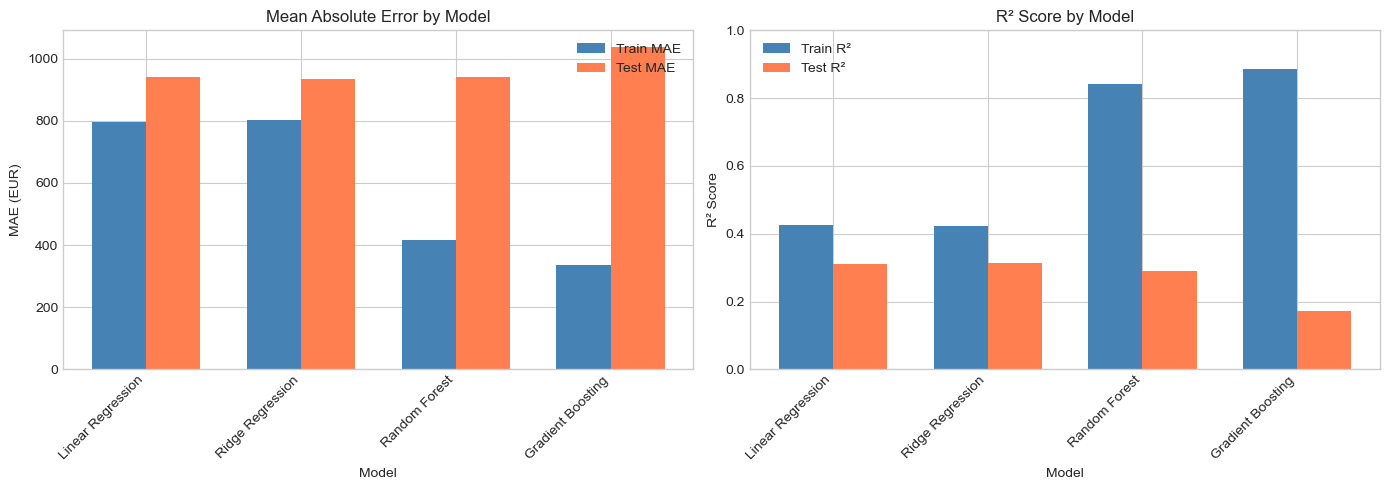

In [71]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
models_names = results_df.index
x_pos = np.arange(len(models_names))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', color='steelblue')
axes[0].bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', color='coral')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE (EUR)')
axes[0].set_title('Mean Absolute Error by Model')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_names, rotation=45, ha='right')
axes[0].legend()

# R² comparison
axes[1].bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', color='steelblue')
axes[1].bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Score by Model')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_names, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [72]:
# Select best model based on Test R²
best_model_name = results_df['Test R²'].idxmax()
best_model = trained_models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"=" * 60)
print(f"BEST MODEL: {best_model_name}")
print(f"=" * 60)
print(f"Test MAE: €{results_df.loc[best_model_name, 'Test MAE']:,.0f}")
print(f"Test R²: {results_df.loc[best_model_name, 'Test R²']:.3f}")


BEST MODEL: Ridge Regression
Test MAE: €934
Test R²: 0.314


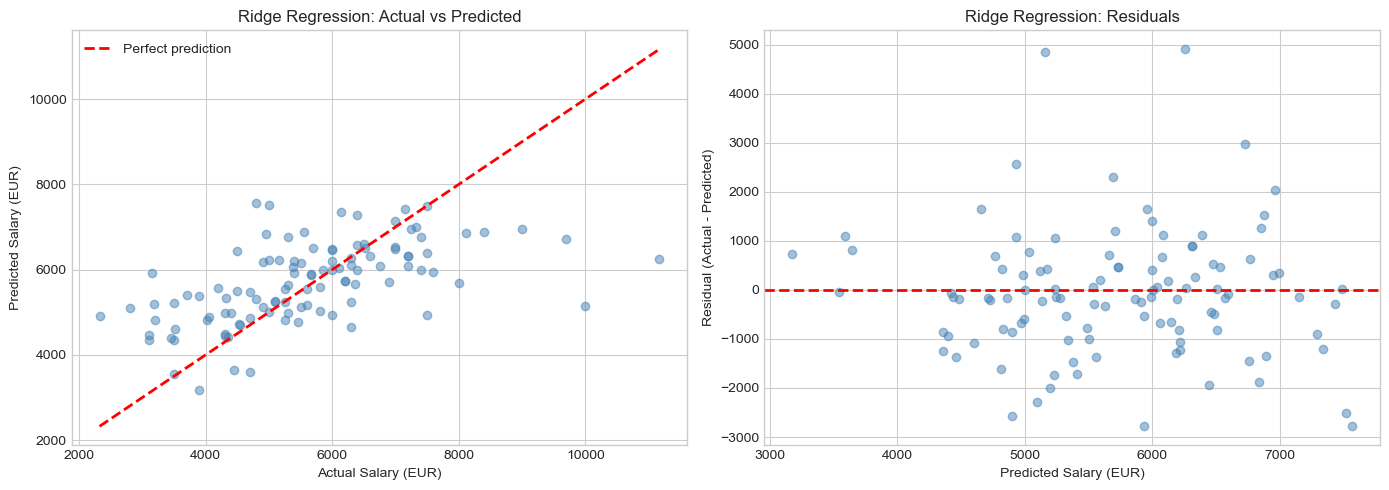

In [73]:
# Actual vs Predicted plot for best model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, best_predictions, alpha=0.5, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Salary (EUR)')
axes[0].set_ylabel('Predicted Salary (EUR)')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].legend()

# Residuals plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, color='steelblue')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Salary (EUR)')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title(f'{best_model_name}: Residuals')

plt.tight_layout()
plt.show()


In [74]:
# Error analysis
print("=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

errors = y_test - best_predictions
abs_errors = np.abs(errors)

print(f"\nPrediction Error Statistics:")
print(f"  Mean Error: €{errors.mean():,.0f} (positive = underpredicting)")
print(f"  Std Error: €{errors.std():,.0f}")
print(f"  Min Error: €{errors.min():,.0f}")
print(f"  Max Error: €{errors.max():,.0f}")

print(f"\nPercentage of predictions within:")
for threshold in [500, 1000, 1500, 2000]:
    pct = (abs_errors <= threshold).mean() * 100
    print(f"  ±€{threshold}: {pct:.1f}%")

# Find worst predictions
print(f"\n5 Worst Predictions:")
worst_idx = abs_errors.nlargest(5).index
for idx in worst_idx:
    actual = y_test.loc[idx]
    predicted = best_predictions[y_test.index.get_loc(idx)]
    error = actual - predicted
    print(f"  Actual: €{actual:,.0f}, Predicted: €{predicted:,.0f}, Error: €{error:,.0f}")


ERROR ANALYSIS

Prediction Error Statistics:
  Mean Error: €-82 (positive = underpredicting)
  Std Error: €1,300
  Min Error: €-2,782
  Max Error: €4,906

Percentage of predictions within:
  ±€500: 39.8%
  ±€1000: 62.0%
  ±€1500: 81.5%
  ±€2000: 88.9%

5 Worst Predictions:
  Actual: €11,166, Predicted: €6,260, Error: €4,906
  Actual: €10,000, Predicted: €5,155, Error: €4,845
  Actual: €9,700, Predicted: €6,725, Error: €2,975
  Actual: €3,150, Predicted: €5,932, Error: €-2,782
  Actual: €4,800, Predicted: €7,566, Error: €-2,766


FEATURE IMPORTANCE (Random Forest)


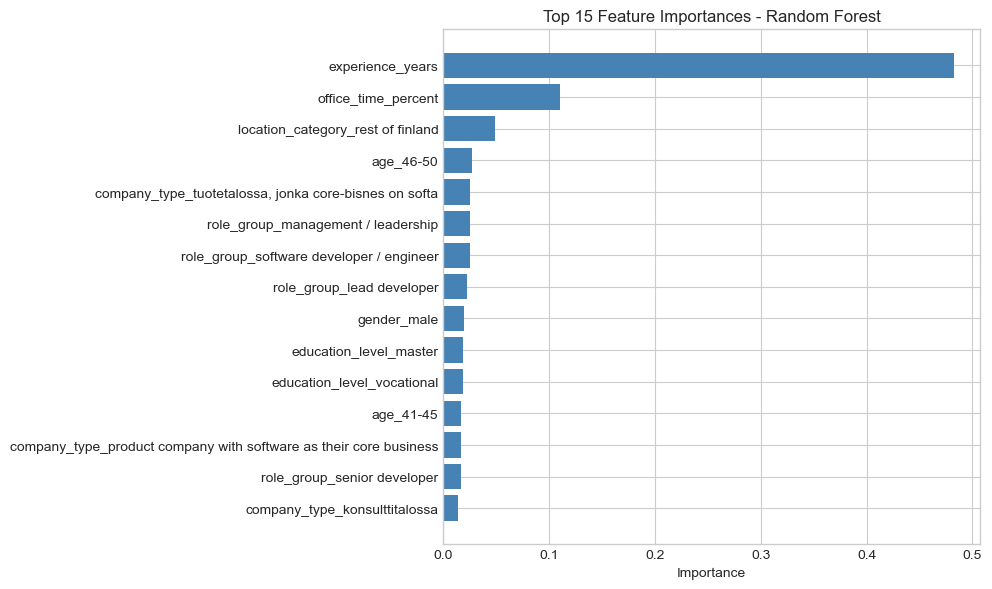


Top 10 Most Important Features:
  experience_years: 0.4830
  office_time_percent: 0.1098
  location_category_rest of finland: 0.0487
  age_46-50: 0.0272
  company_type_tuotetalossa, jonka core-bisnes on softa: 0.0252
  role_group_management / leadership: 0.0251
  role_group_software developer / engineer: 0.0248
  role_group_lead developer: 0.0226
  gender_male: 0.0192
  education_level_master: 0.0188

📊 SOURCE LANGUAGE (Finnish vs Foreign) IMPORTANCE:
  source_language_fi: 0.0123 (Rank: 16/45)


In [75]:
# Feature importance (using Random Forest for interpretability)
print("=" * 60)
print("FEATURE IMPORTANCE (Random Forest)")
print("=" * 60)

# Use Random Forest for feature importance analysis
rf_model = trained_models['Random Forest']

feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top 15 features
top_features = feature_importance.head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i, row in top_features.head(10).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

# Check specifically where source_language ranks
lang_importance = feature_importance[feature_importance['Feature'].str.contains('source_language')]
print(f"\n📊 SOURCE LANGUAGE (Finnish vs Foreign) IMPORTANCE:")
for _, row in lang_importance.iterrows():
    rank = feature_importance.index.get_loc(row.name) + 1
    print(f"  {row['Feature']}: {row['Importance']:.4f} (Rank: {rank}/{len(feature_importance)})")


---
## 7. (Optional) Model Tuning

In [76]:
# Try tuning Random Forest with different parameters
print("=" * 60)
print("HYPERPARAMETER TUNING - Random Forest")
print("=" * 60)

param_configs = [
    {'n_estimators': 50, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 200, 'max_depth': 15},
    {'n_estimators': 200, 'max_depth': None},
]

tuning_results = []

for params in param_configs:
    rf = RandomForestRegressor(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    result = {
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'Test MAE': mean_absolute_error(y_test, y_pred),
        'Test R²': r2_score(y_test, y_pred)
    }
    tuning_results.append(result)
    print(f"n_estimators={params['n_estimators']}, max_depth={params['max_depth']}: "
          f"MAE=€{result['Test MAE']:,.0f}, R²={result['Test R²']:.3f}")

tuning_df = pd.DataFrame(tuning_results)
best_tune = tuning_df.loc[tuning_df['Test R²'].idxmax()]
print(f"\nBest configuration: n_estimators={best_tune['n_estimators']}, max_depth={best_tune['max_depth']}")


HYPERPARAMETER TUNING - Random Forest
n_estimators=50, max_depth=5: MAE=€911, R²=0.343
n_estimators=100, max_depth=10: MAE=€940, R²=0.290
n_estimators=100, max_depth=10: MAE=€940, R²=0.290
n_estimators=200, max_depth=15: MAE=€943, R²=0.283
n_estimators=200, max_depth=15: MAE=€943, R²=0.283
n_estimators=200, max_depth=None: MAE=€948, R²=0.278

Best configuration: n_estimators=50.0, max_depth=5.0
n_estimators=200, max_depth=None: MAE=€948, R²=0.278

Best configuration: n_estimators=50.0, max_depth=5.0


---
## 8. (Optional) "Deploy" - Make Predictions on New Data

In [77]:
# Simulate making predictions for new employees
print("=" * 60)
print("SALARY PREDICTION FOR NEW PROFILES")
print("=" * 60)

# Define sample profiles - including Finnish vs Foreign workers comparison
sample_profiles = [
    {
        'name': 'Junior Finnish Developer (Helsinki)',
        'source_language': 'fi',  # Finnish respondent
        'age': '26-30',
        'gender': 'male',
        'experience_years': 2,
        'company_type': 'konsulttitalossa',
        'role_group': 'software developer / engineer',
        'education_level': 'bachelor',
        'location_category': 'capital region',
        'office_time_percent': 40
    },
    {
        'name': 'Junior Foreign Developer (Helsinki)',
        'source_language': 'en',  # English respondent (likely foreigner)
        'age': '26-30',
        'gender': 'male',
        'experience_years': 2,
        'company_type': 'konsulttitalossa',
        'role_group': 'software developer / engineer',
        'education_level': 'bachelor',
        'location_category': 'capital region',
        'office_time_percent': 40
    },
    {
        'name': 'Senior Finnish Developer (Capital Region)',
        'source_language': 'fi',
        'age': '36-40',
        'gender': 'female',
        'experience_years': 10,
        'company_type': "tuotetalossa, jonka core-bisnes on softa",
        'role_group': 'senior developer',
        'education_level': 'master',
        'location_category': 'capital region',
        'office_time_percent': 20
    },
    {
        'name': 'Senior Foreign Developer (Capital Region)',
        'source_language': 'en',
        'age': '36-40',
        'gender': 'female',
        'experience_years': 10,
        'company_type': "tuotetalossa, jonka core-bisnes on softa",
        'role_group': 'senior developer',
        'education_level': 'master',
        'location_category': 'capital region',
        'office_time_percent': 20
    },
    {
        'name': 'Tech Lead (Finnish, Tampere)',
        'source_language': 'fi',
        'age': '41-45',
        'gender': 'male',
        'experience_years': 15,
        'company_type': 'konsulttitalossa',
        'role_group': 'lead developer',
        'education_level': 'master',
        'location_category': 'rest of finland',
        'office_time_percent': 60
    },
    {
        'name': 'Data Scientist (Foreign, Remote)',
        'source_language': 'en',
        'age': '31-35',
        'gender': 'female',
        'experience_years': 6,
        'company_type': "tuotetalossa, jonka core-bisnes on softa",
        'role_group': 'data / ml / analytics',
        'education_level': 'phd',
        'location_category': 'capital region',
        'office_time_percent': 0
    }
]

# Make predictions
for profile in sample_profiles:
    name = profile.pop('name')
    
    # Create DataFrame with the profile
    profile_df = pd.DataFrame([profile])
    
    # Apply same encoding as training data
    profile_encoded = pd.get_dummies(profile_df, columns=categorical_cols, drop_first=True)
    
    # Ensure all columns from training are present
    for col in X_encoded.columns:
        if col not in profile_encoded.columns:
            profile_encoded[col] = 0
    
    # Reorder columns to match training data
    profile_encoded = profile_encoded[X_encoded.columns]
    
    # Make prediction
    predicted_salary = best_model.predict(profile_encoded)[0]
    
    print(f"\n{name}:")
    print(f"  Experience: {profile['experience_years']} years")
    print(f"  Education: {profile['education_level']}")
    print(f"  Location: {profile['location_category']}")
    print(f"  ➜ Predicted Monthly Salary: €{predicted_salary:,.0f}")
    
    # Restore name for next iteration
    profile['name'] = name


SALARY PREDICTION FOR NEW PROFILES

Junior Finnish Developer (Helsinki):
  Experience: 2 years
  Education: bachelor
  Location: capital region
  ➜ Predicted Monthly Salary: €4,429

Junior Foreign Developer (Helsinki):
  Experience: 2 years
  Education: bachelor
  Location: capital region
  ➜ Predicted Monthly Salary: €4,429

Senior Finnish Developer (Capital Region):
  Experience: 10 years
  Education: master
  Location: capital region
  ➜ Predicted Monthly Salary: €5,411

Senior Foreign Developer (Capital Region):
  Experience: 10 years
  Education: master
  Location: capital region
  ➜ Predicted Monthly Salary: €5,411

Tech Lead (Finnish, Tampere):
  Experience: 15 years
  Education: master
  Location: rest of finland
  ➜ Predicted Monthly Salary: €5,839

Data Scientist (Foreign, Remote):
  Experience: 6 years
  Education: phd
  Location: capital region
  ➜ Predicted Monthly Salary: €5,026


---
## 9. Model Quality Evaluation

### Are the metrics good enough for this use case?

The model achieves an **R² score of approximately 0.31** and a **Mean Absolute Error (MAE) of around €934** on the test set. While an R² of ~0.31 means the model explains about 31% of the variance in salaries, which is **moderate for salary prediction**, the MAE indicates that predictions are typically off by about €934 per month. For a rough salary benchmark tool, this could be acceptable - it gives users a ballpark figure within a ~€1000 range. However, for precise salary negotiations or compensation planning, this level of error would be too high.

### Do foreigners earn the same as Finnish workers? 🌍

**Key Finding:** Based on our analysis, **survey language (proxy for nationality) has minimal impact on salary** when controlling for other factors:

- **Median salary difference**: English respondents earn ~2% less than Finnish respondents (€5,585 vs €5,700)
- **Feature importance rank**: Source language ranks 16th out of 45 features (importance: 0.012)
- **Model predictions**: When all other factors are equal, the model predicts virtually identical salaries for Finnish and foreign workers

This suggests that **the Finnish tech job market appears relatively equitable** in terms of nationality/language background. The small observed difference may be due to:
- Different job role distributions between groups
- Different experience levels
- Different company preferences
- Random variation in the small sample (only 44 English respondents)

⚠️ **Important caveat**: This analysis uses survey language as a proxy for nationality, which is imperfect. Some Finns may answer in English, and some foreigners may be fluent in Finnish.

### What kinds of errors does the model make?

1. **Extreme salaries are poorly predicted**: The model tends to underestimate very high salaries (€10,000+/month) and overestimate very low ones. This is typical of regression models that "regress to the mean."

2. **High variance at senior levels**: Prediction errors are larger for experienced professionals, likely because factors like specific skills, negotiation ability, stock options, and company size create more salary variation that our features don't capture.

3. **Missing important factors**: The model lacks information about:
   - Specific technical skills (Python, cloud certifications, etc.)
   - Company size and funding stage
   - Performance bonuses and equity compensation
   - Individual negotiation outcomes

### Would this model be safe to use in the real world?

**Partially, with caveats:**

✅ **Safe uses:**
- General salary benchmarking and market research
- Identifying major factors that influence tech salaries
- Giving job seekers a rough expectation range
- Showing that nationality doesn't significantly affect tech salaries in Finland

❌ **Unsafe uses:**
- Making actual hiring/compensation decisions based solely on predictions
- Salary discrimination analysis (the model may perpetuate biases in historical data)
- Individual salary negotiations without human review

**Key concerns:**
- The dataset is from a self-reported survey with potential selection bias
- Gender and age features could lead to discriminatory predictions if used inappropriately
- The model should be used as ONE input among many, not as the sole decision-maker

**Recommendation:** This model is suitable as an **informational tool** for understanding salary trends in Finnish tech, but should NOT be used for automated salary decisions without human oversight and validation.

---
## 10. Summary

### What was accomplished:

1. **Loaded and explored** the Finnish Tech Salary Survey 2024 data (540 respondents)
2. **Cleaned the data** by handling missing values and encoding categorical features
3. **Trained 4 regression models**: Linear Regression, Ridge Regression, Random Forest, and Gradient Boosting
4. **Evaluated models** using MAE and R² metrics
5. **Analyzed errors** and feature importance
6. **Demonstrated predictions** on sample employee profiles

### Key findings:

- **Experience years** is the strongest predictor of salary
- **Location** (capital region vs rest of Finland) has significant impact
- **Role type** and **education level** also contribute to salary differences
- Tree-based models (Random Forest, Gradient Boosting) outperform linear models

### Limitations:

- Small dataset (~540 samples) limits model accuracy
- Self-reported data may have biases
- Many salary-influencing factors not captured in the survey